In [1]:
# Importing necessary packages
import os
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score



from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'logger_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

In [2]:
# Reading the dataset
dataset_path = "/kaggle/input/us-stock-market-2020-to-2024/US Stock Market Dataset.csv"

try:
    # Attempt to read the dataset
    df = pd.read_csv(dataset_path)
    logger.info(f"Dataset loaded successfully from {dataset_path}")
except FileNotFoundError:
    logger.error("Error: Dataset file not found. Please provide the correct file path.")
except Exception as e:
    logger.error(f"An error occurred: {e}")
    
# Rename the first column
df = df.rename(columns={df.columns[0]: 'date_index'})
print(df.columns)

df = df[['date_index','Natural_Gas_Price','Natural_Gas_Vol.','Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.']]
df['prev_index'] = df['date_index'] + 1
df.head(5)

Index(['date_index', 'Date', 'Natural_Gas_Price', 'Natural_Gas_Vol.',
       'Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.',
       'Bitcoin_Price', 'Bitcoin_Vol.', 'Platinum_Price', 'Platinum_Vol.',
       'Ethereum_Price', 'Ethereum_Vol.', 'S&P_500_Price', 'Nasdaq_100_Price',
       'Nasdaq_100_Vol.', 'Apple_Price', 'Apple_Vol.', 'Tesla_Price',
       'Tesla_Vol.', 'Microsoft_Price', 'Microsoft_Vol.', 'Silver_Price',
       'Silver_Vol.', 'Google_Price', 'Google_Vol.', 'Nvidia_Price',
       'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
       'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
       'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'],
      dtype='object')


,date_index,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,prev_index
0,0,2.079,NaN,72.28,NaN,3.8215,NaN,1
1,1,2.050,161340.0,73.82,577940.0,3.8535,NaN,2
2,2,2.100,142860.0,75.85,344490.0,3.9060,NaN,3
3,3,2.077,139750.0,77.82,347240.0,3.9110,NaN,4
4,4,2.490,3590.0,76.78,331930.0,3.8790,NaN,5


In [3]:
def get_prev_pane(df,y,index_col):
    df['prev_index'] = df[index_col] + y
    column_names = df.columns
    df_tmp = pd.merge(df, df, left_on=index_col, right_on='prev_index', how='inner', suffixes=("_"+str(y),''))
    df_tmp = df_tmp.drop(column_names,axis=1)
    df_tmp = df_tmp.drop(['prev_index'+"_"+str(y),index_col+"_"+str(y)],axis=1)
    return df_tmp

In [4]:
window_back = 100

for i in range (0,window_back,1):
    prev_df = get_prev_pane(df,i,'date_index')
    if i == 0:
        final_df = prev_df
    else:
        final_df = pd.merge(final_df, prev_df, left_index=True, right_index=True)
    
final_df = final_df.iloc[:-window_back]
final_df

,Natural_Gas_Price_0,Natural_Gas_Vol._0,Crude_oil_Price_0,Crude_oil_Vol._0,Copper_Price_0,Copper_Vol._0,Natural_Gas_Price_1,Natural_Gas_Vol._1,Crude_oil_Price_1,Crude_oil_Vol._1,...,Crude_oil_Price_98,Crude_oil_Vol._98,Copper_Price_98,Copper_Vol._98,Natural_Gas_Price_99,Natural_Gas_Vol._99,Crude_oil_Price_99,Crude_oil_Vol._99,Copper_Price_99,Copper_Vol._99
0,2.079,NaN,72.28,NaN,3.8215,NaN,2.050,161340.0,73.82,577940.0,...,88.52,345970.0,3.7930,53840.0,2.743,202190.0,88.84,341140.0,3.7920,44010.0
1,2.050,161340.0,73.82,577940.0,3.8535,NaN,2.100,142860.0,75.85,344490.0,...,88.84,341140.0,3.7920,44010.0,2.608,110880.0,87.29,292390.0,3.8070,66660.0
2,2.100,142860.0,75.85,344490.0,3.9060,NaN,2.077,139750.0,77.82,347240.0,...,87.29,292390.0,3.8070,66660.0,2.605,101230.0,87.51,294440.0,3.7165,66660.0
3,2.077,139750.0,77.82,347240.0,3.9110,NaN,2.490,3590.0,76.78,331930.0,...,87.51,294440.0,3.7165,66660.0,2.579,140330.0,86.87,270740.0,3.7620,69660.0
4,2.490,3590.0,76.78,331930.0,3.8790,NaN,2.712,73020.0,78.01,365460.0,...,86.87,270740.0,3.7620,69660.0,2.510,116660.0,87.54,307120.0,3.7860,68210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,3.024,35710.0,38.56,360180.0,3.0895,74730.0,2.971,73250.0,39.85,268930.0,...,37.41,307610.0,2.4965,70.0,1.821,200600.0,37.29,494250.0,2.4950,50.0
810,2.971,73250.0,39.85,268930.0,3.1290,50620.0,3.007,93190.0,40.64,307490.0,...,37.29,494250.0,2.4950,50.0,1.777,142960.0,36.81,343480.0,2.4985,30.0
811,3.007,93190.0,40.64,307490.0,3.1535,74340.0,3.023,154370.0,40.03,366900.0,...,36.81,343480.0,2.4985,30.0,1.774,205240.0,35.44,385710.0,2.4780,110.0
812,3.023,154370.0,40.03,366900.0,3.1985,80170.0,2.913,119810.0,41.46,24520.0,...,35.44,385710.0,2.4780,110.0,1.849,221370.0,35.49,443650.0,2.4345,80.0


In [5]:
col_names = final_df.columns[1:].tolist()

# creating a copy of df
df1 = final_df.fillna(0)

#target column name
label_name = 'Natural_Gas_Price_0'


# defining the features and target
X = df1.drop([label_name],axis=1)
y = df1[[label_name]]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[col_names] = scaler.fit_transform(X[col_names])

# Get centering and scaling values for each feature
centering = scaler.center_
iqrs  = scaler.scale_

X.head()

,Natural_Gas_Vol._0,Crude_oil_Price_0,Crude_oil_Vol._0,Copper_Price_0,Copper_Vol._0,Natural_Gas_Price_1,Natural_Gas_Vol._1,Crude_oil_Price_1,Crude_oil_Vol._1,Copper_Price_1,...,Crude_oil_Price_98,Crude_oil_Vol._98,Copper_Price_98,Copper_Vol._98,Natural_Gas_Price_99,Natural_Gas_Vol._99,Crude_oil_Price_99,Crude_oil_Vol._99,Copper_Price_99,Copper_Vol._99
0,-1.736350,-0.261232,-2.411437,-0.168546,-0.215353,-0.443011,0.646529,-0.169466,1.771987,-0.117717,...,0.645413,0.066270,-0.159219,0.698839,-0.123233,1.191491,0.663609,0.031301,-0.159776,0.553503
1,0.641368,-0.169592,1.771987,-0.117903,-0.215353,-0.424583,0.371201,-0.048759,0.082157,-0.034762,...,0.659681,0.031402,-0.160543,0.552084,-0.171246,-0.134388,0.594250,-0.319482,-0.140010,0.891651
2,0.369022,-0.048795,0.082157,-0.034817,-0.215353,-0.433060,0.324866,0.068381,0.102063,-0.026862,...,0.590570,-0.320520,-0.140682,0.890233,-0.172313,-0.274513,0.604094,-0.304731,-0.259265,0.891651
3,0.323189,0.068432,0.102063,-0.026904,-0.215353,-0.280844,-1.703740,0.006541,-0.008759,-0.077424,...,0.600379,-0.305721,-0.260510,0.890233,-0.181560,0.293244,0.575456,-0.475265,-0.199308,0.936439
4,-1.683443,0.006546,-0.008759,-0.077547,-0.215353,-0.199023,-0.669324,0.079679,0.233949,-0.120087,...,0.571843,-0.476809,-0.200265,0.935020,-0.206099,-0.050459,0.605437,-0.213492,-0.167682,0.914791


In [6]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [7]:
# Defining a dictionary of regression models
regressors = {
    'AdaBoostRegressor': AdaBoostRegressor(),
    'LinearRegression': LinearRegression(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=300, max_depth=1, subsample=0.8, max_features=0.2),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
}

AdaBoostRegressor CV Scores: [-0.08053556 -0.05969323 -0.07484313 -0.08666596 -0.06505812]
AdaBoostRegressor Mean Squared Error (MSE): 0.07223912357250477
AdaBoostRegressor Root Mean Squared Error (RMSE): 0.2687733684212496
AdaBoostRegressor Mean Absolute Error (MAE): 0.19115389662856966
AdaBoostRegressor R^2 Score: 0.9789431409580795


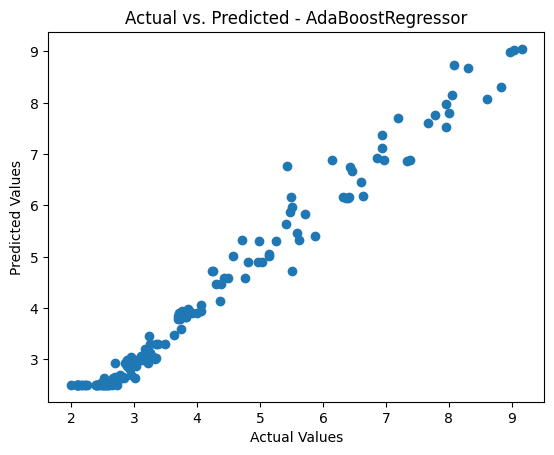

LinearRegression CV Scores: [-0.62919224 -0.61274547 -0.47373737 -0.69279498 -0.58975034]
LinearRegression Mean Squared Error (MSE): 0.5359227646282478
LinearRegression Root Mean Squared Error (RMSE): 0.7320674590693454
LinearRegression Mean Absolute Error (MAE): 0.5853659877011317
LinearRegression R^2 Score: 0.8437847864972088


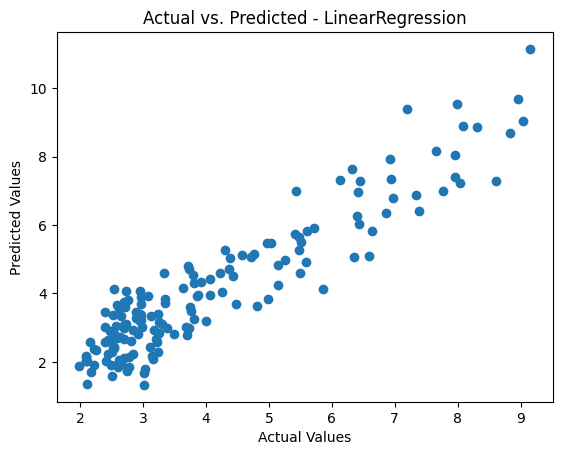

KNeighborsRegressor CV Scores: [-0.18977672 -0.13688933 -0.10222626 -0.12376598 -0.12632863]
KNeighborsRegressor Mean Squared Error (MSE): 0.0982503936196319
KNeighborsRegressor Root Mean Squared Error (RMSE): 0.3134491882580523
KNeighborsRegressor Mean Absolute Error (MAE): 0.2399288343558283
KNeighborsRegressor R^2 Score: 0.9713611601726405


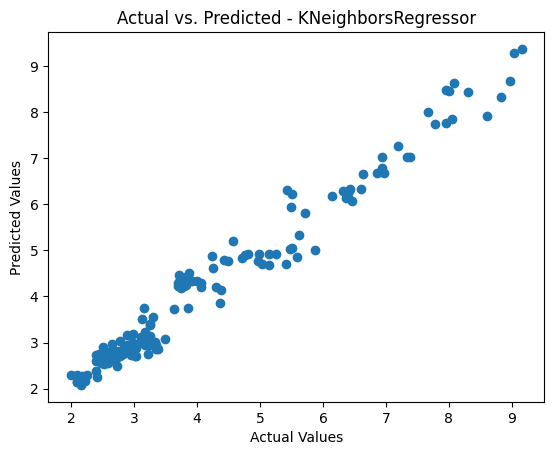

RandomForestRegressor CV Scores: [-0.059076   -0.05091487 -0.06590838 -0.06321223 -0.05580876]
RandomForestRegressor Mean Squared Error (MSE): 0.05415078182822099
RandomForestRegressor Root Mean Squared Error (RMSE): 0.23270320545325754
RandomForestRegressor Mean Absolute Error (MAE): 0.1516890797546014
RandomForestRegressor R^2 Score: 0.9842156808723987


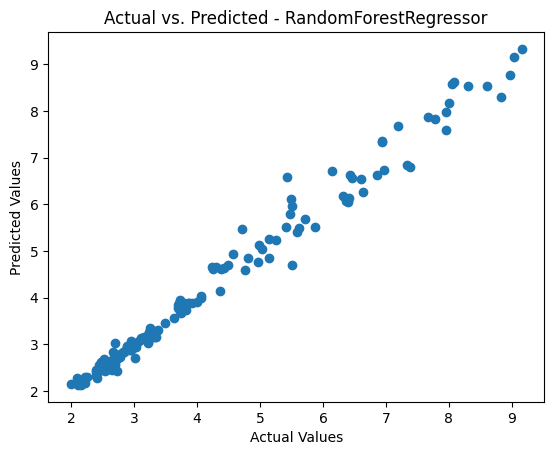

GradientBoostingRegressor CV Scores: [-0.1042936  -0.07605241 -0.10008554 -0.08360327 -0.06494524]
GradientBoostingRegressor Mean Squared Error (MSE): 0.07886821526125797
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.2808348540713171
GradientBoostingRegressor Mean Absolute Error (MAE): 0.19002173456115412
GradientBoostingRegressor R^2 Score: 0.977010838317033


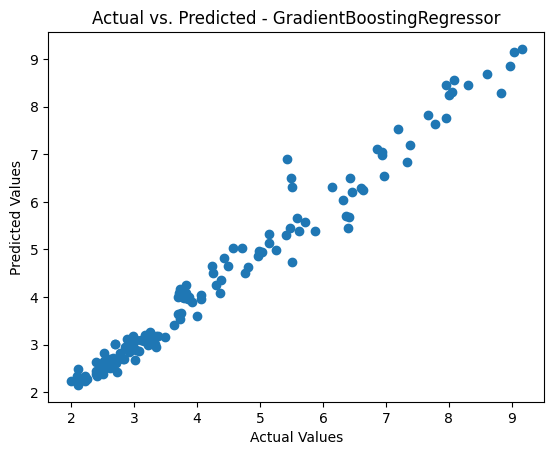

XGBRegressor CV Scores: [-0.07468523 -0.0588049  -0.07173101 -0.06276878 -0.06675703]
XGBRegressor Mean Squared Error (MSE): 0.05917180018749656
XGBRegressor Root Mean Squared Error (RMSE): 0.24325254405143754
XGBRegressor Mean Absolute Error (MAE): 0.15577053920769254
XGBRegressor R^2 Score: 0.9827521127861657


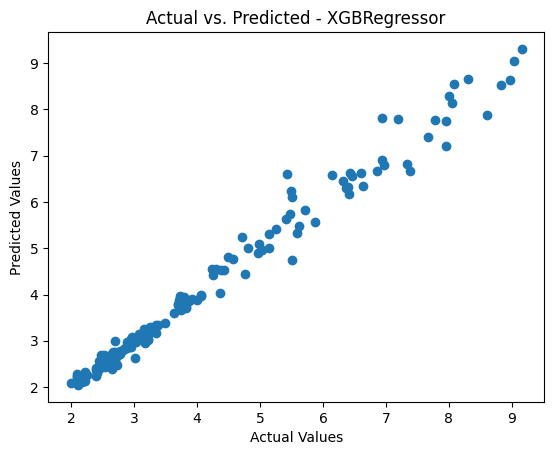

In [8]:
# Improved model evaluation and cross-validation for regression
model_results = []

# Looping through regression models and evaluating their performance
for name, model in regressors.items():
    try:
        logger.info(f"Training and evaluating {name} model.")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

        # Model training
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Evaluation metrics for regression
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})
        
        print("=============================================================================")
        print(name, "CV Scores:", cv_scores)
        print(name, "Mean Squared Error (MSE):", mse)
        print(name, "Root Mean Squared Error (RMSE):", rmse)
        print(name, "Mean Absolute Error (MAE):", mae)
        print(name, "R^2 Score:", r2)
        
        logger.info(f"{name} - CV Scores: {cv_scores}")
        logger.info(f"{name} - MSE: {mse}")
        logger.info(f"{name} - RMSE: {rmse}")
        logger.info(f"{name} - MAE: {mae}")
        logger.info(f"{name} - R^2 Score: {r2}")

        # Plotting the actual vs. predicted values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs. Predicted - {name}')
        plt.show()

    except Exception as ex:
        print(ex)
        logger.error(f"An error occurred while processing {name} model: {ex}")


In [9]:
df_results = pd.DataFrame(model_results)
df_results

,Model,MSE,RMSE,MAE,R^2,CV Scores
0,AdaBoostRegressor,0.072239,0.268773,0.191154,0.978943,"[-0.08053556467541612, -0.05969322930346595, -..."
1,LinearRegression,0.535923,0.732067,0.585366,0.843785,"[-0.6291922355444032, -0.6127454679309101, -0...."
2,KNeighborsRegressor,0.098250,0.313449,0.239929,0.971361,"[-0.1897767224427481, -0.13688932953846153, -0..."
3,RandomForestRegressor,0.054151,0.232703,0.151689,0.984216,"[-0.059075995237404616, -0.050914871484615425,..."
4,GradientBoostingRegressor,0.078868,0.280835,0.190022,0.977011,"[-0.1042936034187171, -0.07605240521363957, -0..."
5,XGBRegressor,0.059172,0.243253,0.155771,0.982752,"[-0.07468522914067081, -0.05880489558761278, -..."


In [10]:
# Save log messages to a file
# File handling: close the FileHandler
file_handler.close()
logger.removeHandler(file_handler)